# Оценка юнит-экономики для маркетплейса

Цель: оценить текущие показатели юнит-экономики и предложить меры по их оптимизации.

Содержание:

1. Загрузка данных
2. Расчет ключевых метрик
3. Когортный анализ для покупателей
4. Когортный анализ для продавцов
5. Выводы и рекомендации



## 1. Загрузка и проверка данных

In [1]:
# Импортируем библеотеки
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загружаем таблицы
seller_data = pd.read_csv('/content/drive/MyDrive/zerocod/m09/seller_data - seller_data.csv')
sellers_cohort = pd.read_csv('/content/drive/MyDrive/zerocod/m09/sellers_cohort_analysis_data - sellers_cohort_analysis_data.csv')
buyers_cohort = pd.read_csv('/content/drive/MyDrive/zerocod/m09/cohort_analysis_data - cohort_analysis_data.csv')

In [3]:
# Создаем списки с датафреймами и их названиями
names_dfs = ['seller_data', 'sellers_cohort', 'buyers_cohort']
dfs = [seller_data, sellers_cohort, buyers_cohort]

# Выводим информацию по каждому датафрейму
for name,df in zip(names_dfs, dfs):
    print(f'Датафрейм {name}:')
    df.info()
    display(df.head())
    print('===' * 20)

Датафрейм seller_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Seller_ID            999 non-null    int64  
 1   Order_Value          999 non-null    float64
 2   Commission_Rate      999 non-null    float64
 3   Promotion_Used       999 non-null    bool   
 4   Subscription         999 non-null    bool   
 5   Promotion_Income     999 non-null    int64  
 6   Subscription_Income  999 non-null    int64  
dtypes: bool(2), float64(2), int64(3)
memory usage: 41.1 KB


,Seller_ID,Order_Value,Commission_Rate,Promotion_Used,Subscription,Promotion_Income,Subscription_Income
0,2,1930.867849,0.084183,True,True,5000,3000
1,3,2323.844269,0.105457,True,False,5000,0
2,4,2761.514928,0.108259,True,False,5000,0
3,5,1882.923313,0.081263,False,False,0,0
4,6,1882.931522,0.117448,False,False,0,0


Датафрейм sellers_cohort:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   seller_id          500 non-null    int64 
 1   registration_date  500 non-null    object
 2   activity_1_month   500 non-null    int64 
 3   activity_3_month   500 non-null    int64 
 4   activity_6_month   500 non-null    int64 
 5   activity_12_month  500 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 23.6+ KB


,seller_id,registration_date,activity_1_month,activity_3_month,activity_6_month,activity_12_month
0,1,2021-03-23,1,0,0,0
1,2,2022-11-30,0,0,0,1
2,3,2021-11-17,0,1,0,0
3,4,2021-09-06,1,1,0,0
4,5,2021-01-04,1,1,0,0


Датафрейм buyers_cohort:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1000 non-null   int64 
 1   registration_date  1000 non-null   object
 2   activity_1_month   1000 non-null   int64 
 3   activity_3_month   1000 non-null   int64 
 4   activity_6_month   1000 non-null   int64 
 5   activity_12_month  1000 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


,user_id,registration_date,activity_1_month,activity_3_month,activity_6_month,activity_12_month
0,1,2021-06-09,0,1,0,0
1,2,2021-08-09,0,0,0,0
2,3,2021-07-12,0,0,0,0
3,4,2022-04-13,0,0,0,0
4,5,2021-01-24,1,0,0,0


Пропуски отсутствуют, типы данных соответствуют своим значениям, кроме полей с датами. Приведем поля с датами к нужному типу данных и заменим названия столбцов в датафрейме `seller_data`, чтобы все датафреймы соответствовали общему стилю.

In [4]:
# Составим функцию для переименования столбцов
def to_snake_case(column_name):
    return column_name.lower()

# Применяем ко всем колонкам
seller_data.columns = [to_snake_case(col) for col in seller_data.columns]

In [5]:
# Заменим тип данных в полях с датами
sellers_cohort['registration_date'] = pd.to_datetime(sellers_cohort['registration_date'])
buyers_cohort['registration_date'] = pd.to_datetime(buyers_cohort['registration_date'])

Данные подготовлены, можно приступать к расчетам.

## 2. Расчет ключевых метрик

In [6]:
# Дополнительные исходные данные

# Средний доход с одного покупателя в месяц
arpu_buyer = 2000

# Средняя продолжительность взаимодействия для покупателей (в месяцах)
lifetime_buyer = 24

# Средняя продолжительность взаимодействия для продавцов (в месяцах)
lifetime_seller = 18

# Маркетинговые расходы на привлечение в месяц
cost_advert = 3000000

# Cредний объем привлекаемых покупателей в месяц
new_buyer = 2000

# Cредний объем привлекаемых продавцов в месяц
new_seller = 500

# Операционные расходы на поддержание платформы в месяц
cost_operating = 1500000

# Расходы на обслуживание каждого продавца в месяц
cost_service_seller = 1000

# Удержание продавцов
retention_seller = 0.4

# Удержание покупателей
retention_buyer = 0.2

In [7]:
# Считаем другие данные

# Средний чек с каждой продажи
aov_sales = round(seller_data['order_value'].mean(), 1)

# Средняя комиссия
avg_commision = round(seller_data['commission_rate'].mean(), 1)

# Средняя комиссия с каждой продажи
avg_sales_commision = round((seller_data['order_value'] *
                             seller_data['commission_rate']).mean(), 1)

# Средний доход с продавца
arpu_seller = round((seller_data['order_value'] *
                      seller_data['commission_rate'] +
                      seller_data['promotion_income'] +
                      seller_data['subscription_income']).mean(), 1)

# Процент продавцов, использующих платные инструменты продвижения
percent_sellers_is_promotion = round((seller_data['promotion_used'].sum() /
                                      seller_data.shape[0] * 100), 1)

# Процент продавцов, использующих платную подписку
percent_sellers_is_subscription = round((seller_data['subscription'].sum() /
                                         seller_data.shape[0] * 100), 1)

In [8]:
# Создаем датафрейм с маркетинговыми расчетами
metrics = pd.DataFrame([
  {
    'user_type': 'buyer',
    'cac': round(cost_advert / new_buyer, 1),
    'ltv': round((aov_sales * avg_commision) * lifetime_buyer * retention_buyer, 1)
  },
  {
    'user_type': 'seller',
    'cac': round(cost_advert / new_seller, 1),
    'ltv': round((arpu_seller - cost_service_seller) * lifetime_seller * retention_seller, 1)
  }
])

# Считаем ROI
metrics['roi'] = round((metrics['ltv'] - metrics['cac']) / metrics['cac'] * 100, 1)

# Проверяем результат
metrics

,user_type,cac,ltv,roi
0,buyer,1500.0,964.5,-35.7
1,seller,6000.0,16822.8,180.4


На основе расчетов мы выделили несколько проблемных зон:

* высокие затраты на привлечение покупателей (CAC). Покупатель приносит доход 965 рублей, но его привлечение стоит 1500 рублей, что приводит к отрицательному ROI;
* низкое удержание покупателей. Уровень удержания всего 20%, что говорит о необходимости работы над увеличением пожизненной ценности клиента (LTV);
* высокие затраты на привлечение продавцов. Несмотря на положительный ROI, стоимость привлечения продавцов остается высокой, что может стать проблемой при масштабировании бизнеса.

## 3. Когортный анализ для покупателей

In [9]:
# Извлекаем месяц для группировки по когортам
buyers_cohort['month_cohort'] = buyers_cohort['registration_date'].dt.to_period('M')

In [10]:
# Группируем по когортам и считаем коэффициент удержания
cohort_pivot = buyers_cohort.groupby('month_cohort').agg({
    'activity_1_month': 'mean',
    'activity_3_month': 'mean',
    'activity_6_month': 'mean',
    'activity_12_month': 'mean',
})

# Округляем значения и переводим в проценты
cohort_pivot = round(cohort_pivot * 100, 1)

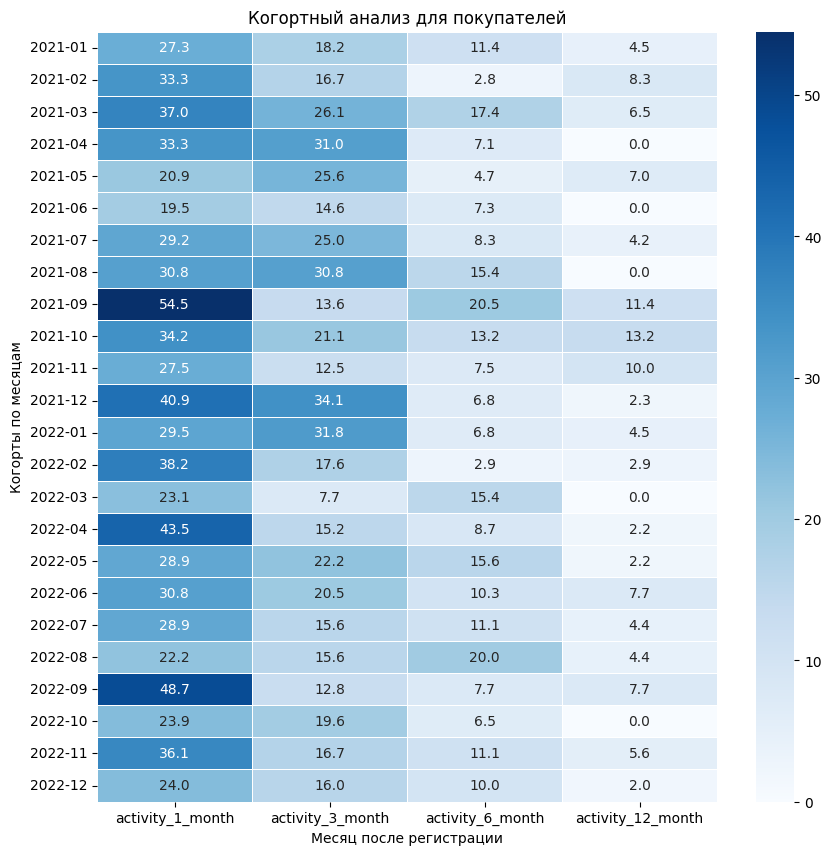

In [11]:
# Построение тепловой карты
plt.figure(figsize=(10, 10))
sns.heatmap(cohort_pivot, annot=True, fmt='.1f', cmap='Blues', linewidths=0.5)
plt.title('Когортный анализ для покупателей')
plt.xlabel('Месяц после регистрации')
plt.ylabel('Когорты по месяцам')
plt.show()

Выводы после проведения когортного анализа:

* На карте видно, что пользователи продолжают совершать целевые действия в течение длительного времени. Например, в декабре отчетливо заметно, что через три месяца они продолжают делать покупки, что говорит о хорошем удержании. Этот тренд продолжается на протяжении шести месяцев, а в отдельных случаях — даже через год, хотя показатели начинают снижаться.
* Самый стабильный месяц — октябрь. Несмотря на то, что начальные значения не такие высокие, спустя три месяца наблюдается стабильная активность, и спустя год хоть кто-то продолжает покупать. Это указывает на успешные маркетинговые кампании, запущенные в этих периодах.
* Сентябрь и декабрь — ключевые месяцы, которые можно объяснить сезонными факторами. В сентябре люди готовятся к школе, а декабрь — время предновогодних покупок. Однако интересно, что в декабре 2022 года наблюдались низкие значения, несмотря на традиционно высокие продажи в этот период.
* Успешные когорты сентябрь и декабрь, а также апрель 2022 года. Можно проанализировать маркетинговые кампании и предложения, которые были предложены в эти месяцы, чтобы использовать этот опыт для оптимизации стратегий в будущем.

## 4. Когортный анализ для продавцов

In [12]:
# Извлекаем месяц для группировки по когортам
sellers_cohort['month_cohort'] = sellers_cohort['registration_date'].dt.to_period('M')

In [13]:
# Группируем по когортам и считаем коэффициент удержания
cohort_pivot_2 = sellers_cohort.groupby('month_cohort').agg({
    'activity_1_month': 'mean',
    'activity_3_month': 'mean',
    'activity_6_month': 'mean',
    'activity_12_month': 'mean',
})

# Округляем значения и переводим в проценты
cohort_pivot_2 = round(cohort_pivot_2 * 100, 1)

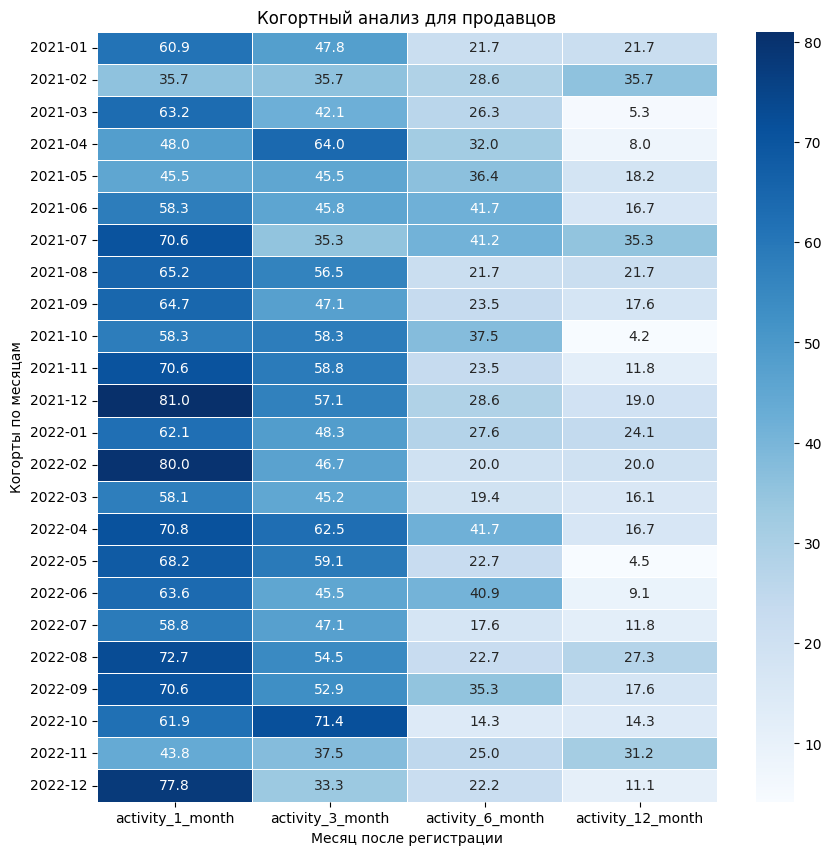

In [14]:
# Построение тепловой карты
plt.figure(figsize=(10, 10))
sns.heatmap(cohort_pivot_2, annot=True, fmt='.1f', cmap='Blues', linewidths=0.5)
plt.title('Когортный анализ для продавцов')
plt.xlabel('Месяц после регистрации')
plt.ylabel('Когорты по месяцам')
plt.show()

Выводы после проведения когортного анализа:
* Продавцы, как правило, более заинтересованы в активности на платформе, однако спустя три месяца удержание продавцов резко падает, что указывает на проблемы с долгосрочным удержанием.
* Первые месяцы работы продавцов на платформе показывают хорошие результаты. Это говорит о привлекательности платформы и удобстве интерфейса. Но спустя три месяца наблюдается резкое снижение активности, что может быть связано с недостаточной ценностью платформы на долгосрочной основе.

## Выводы и рекомендации

Проблемы, которые требуют решения:

* Высокие затраты на привлечение клиентов (CAC) при низком уровне удержания.
* Низкое удержание пользователей, что приводит к сокращению их жизненного цикла на платформе.
* Ограниченные возможности увеличения LTV (пожизненной ценности клиента) как для покупателей, так и для продавцов.

Возможные решения:

* Для повышения уровня удержания необходимо проанализировать, какие маркетинговые кампании и стратегии были использованы в успешные периоды и можно ли их масштабировать на другие месяцы.
* Особое внимание стоит уделить качеству обслуживания и интерфейсу, чтобы минимизировать неудовлетворенность пользователей и продавцов, которая может быть причиной их ухода с платформы.
* Операционные расходы на продавцов могут быть снижены за счет автоматизации процессов и использования чат-ботов для поддержки, что также позволит улучшить взаимодействие с платформой.
* Сегментация клиентов для выявления наиболее перспективных групп.
* Введение программ лояльности.